# Credit Card Fraud Detection -- Deep Learning Seminar

Author: Saskia Setio

Date: 27. February 2023


This Jupyter Notebook contains the code of the deep learning seminar project "Credit Card Fraud Detection" by Thi Thanh Thao Nguyen and Saskia Setio.

The dataset used in this project can be downloaded from https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud?resource=download.

Import Packages:

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, precision_recall_curve, auc, average_precision_score
#from sklearn.metrics import plot_confusion_matrix
from scikeras.wrappers import KerasClassifier

from imblearn.metrics import geometric_mean_score, specificity_score

Definition of functions used throughout the project:

In [81]:
#define function for scatter plot of data
# source: https://www.kaggle.com/code/adamkarwowski/deep-learning-for-fraud-detection
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Non-Fraud", alpha = 0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Fraud", alpha = 0.5, linewidth=0.15, c='r')
    plt.xlabel('V1 scaled')
    plt.ylabel('V2 scaled')
    plt.legend()
    return plt.show()

#define prep_data function converting DataFrame into two variabes X: data columns V1-V28, Log Amount; Y: label column
# source: https://www.kaggle.com/code/adamkarwowski/deep-learning-for-fraud-detection
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    X = df.iloc[:, 1:30].values #drop Time
    y = df.Class.values
    #Feature scaling
    X = (X - X.min())/(X.max() - X.min())
    return X, y

#define heatmap function for performance comparison
# Source: https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on the bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im , cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


#define performance function calculating desired metrics for performance comparison
def performance(y_test, y_pred):
    #Calculates Overall Accuracy, Precision, Recall, Specificity, F1, ROC-AUC, AUPRC and G-Mean of classification model
    y_pred_classed = np.round(y_pred)
    accuracy = accuracy_score(y_test,y_pred_classed)
    precision = precision_score(y_test,y_pred_classed)
    recall = recall_score(y_test,y_pred_classed)
    specificity = specificity_score(y_test,y_pred_classed)
    f1 = f1_score(y_test,y_pred_classed)
    roc_auc = roc_auc_score(y_test,y_pred)
    auprc = average_precision_score(y_test,y_pred)
    g_mean = (precision*recall)**.5
    print("Overall Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    print("Specificity: ", specificity)
    print("F1: ", f1)
    print("ROC-AUC Score: ", roc_auc)
    print("Average Precision Score: ", auprc)
    print("G-Mean: ", g_mean)
    arr = [accuracy, precision, recall, specificity, f1, roc_auc, auprc, g_mean]
    return arr


Load Dataset:

In [3]:
df = pd.read_csv('creditcard.csv') 

Descriptive analysis

In [4]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
description = df.describe()

In [5]:
var = df.var(ddof=0)
description = description.append(np.transpose(pd.DataFrame(var)))
description.rename(index={0: 'var'}, inplace=True)
description

/var/folders/m7/5lvln32n76vg4hhc2bkwf07w0000gn/T/ipykernel_24990/3057077421.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  description = description.append(np.transpose(pd.DataFrame(var)))


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00
var,2255116088.12,3.84,2.73,2.30,2.00,1.91,1.77,1.53,1.43,1.21,1.19,1.04,1.00,0.99,0.92,0.84,0.77,0.72,0.70,0.66,0.59,0.54,0.53,0.39,0.37,0.27,0.23,0.16,0.11,62559.85,0.00


V1-V28 results of PCA transformation, 'Time' and 'Amount' only features not transformed.
Both 'Time' and 'Amount' have a high variation in comparison to the other features. 
--> Drop 'Time' and take log of 'Amount' to reduce its range.

In [6]:
# The `Amount` column covers a huge range. Convert to log-space.
eps = 0.001 # 0 => 0.1¢
df['Log Amount'] = np.log(df.pop('Amount')+eps)
df = df[['Time','V1','V2','V3','V4','V5','V6','V7','V8','V9','V10','V11','V12','V13',
                   'V14','V15','V16','V17','V18','V19','V20','V21','V22','V23','V24',
                   'V25','V26','V27','V28','Log Amount','Class']]

In [7]:
np.var(df['Log Amount']) #comparision to Amount with var of 62559.85

4.095287915447813

Print count and ratio of fraud / non-fraud

In [8]:
#count occurences of fraud and no fraud
occ = df['Class'].value_counts()
print(occ)

#ratio of fraud cases
print(occ / df.shape[0])

0    284315
1       492
Name: Class, dtype: int64
0   1.00
1   0.00
Name: Class, dtype: float64


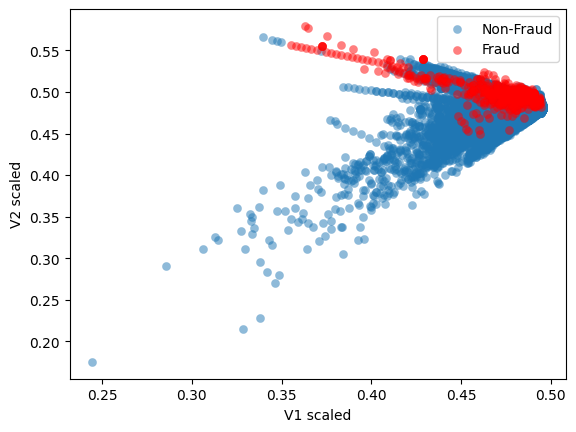

In [9]:
#prepare data
X, y = prep_data(df)
#plot data V1 scaled with V2 scaled
plot_data(X, y)

## Resampling Methods

### 1. Random Undersampling

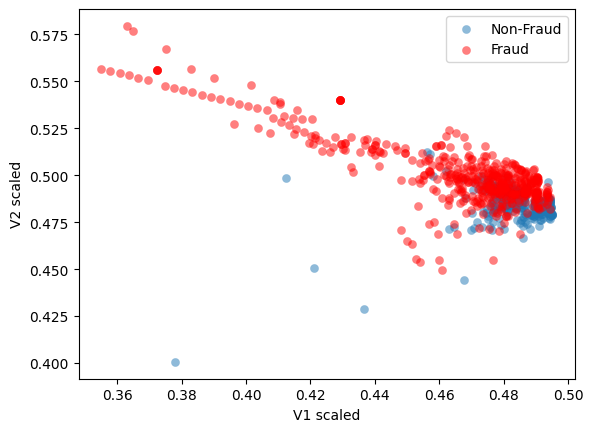

0    492
1    492
dtype: int64


In [10]:
#define resampling method: RandomUnderSampler
RUS = RandomUnderSampler()

#create resampled feature set
random.seed(1)
X_RUS, y_RUS = RUS.fit_resample(X, y)

#plot resampled data
plot_data(X_RUS, y_RUS)

#value counts resampled labels y_resampled
print(pd.value_counts(pd.Series(y_RUS)))

### 2. Near Miss

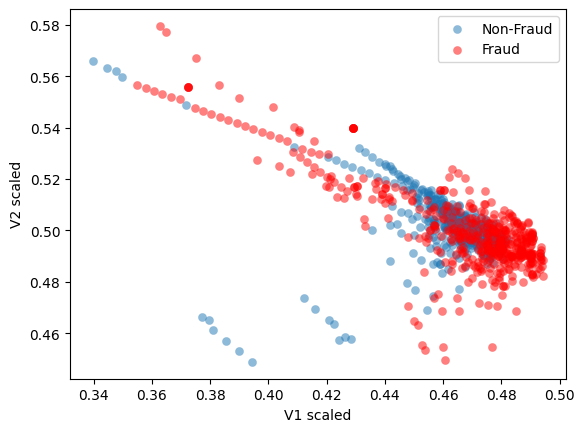

0    492
1    492
dtype: int64


In [11]:
#define resampling method: NearMiss
NM2 = NearMiss(version=2) #NearMiss version 3: Majority class examples with minimum distance to each minority class example.

#create resampled feature set
X_NM2, y_NM2 = NM2.fit_resample(X, y)

#plot resampled data
plot_data(X_NM2, y_NM2)

#value counts resampled labels y_resampled
print(pd.value_counts(pd.Series(y_NM2)))

### 3. Random Oversampling

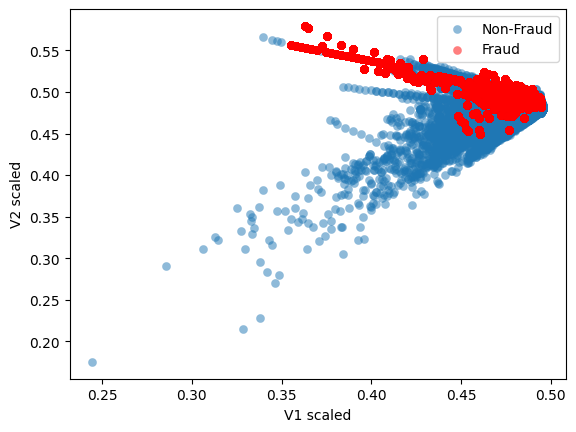

0    284315
1    284315
dtype: int64


In [12]:
#define resampling method: RandomOversampler
ROS = RandomOverSampler()

#create resampled feature set
random.seed(1)
X_ROS, y_ROS = ROS.fit_resample(X, y)

#plot resampled data
plot_data(X_ROS, y_ROS)

#value counts resampled labels y_resampled
print(pd.value_counts(pd.Series(y_ROS)))

### 4. Synthetic Minority Oversampling Technique (SMOTE)

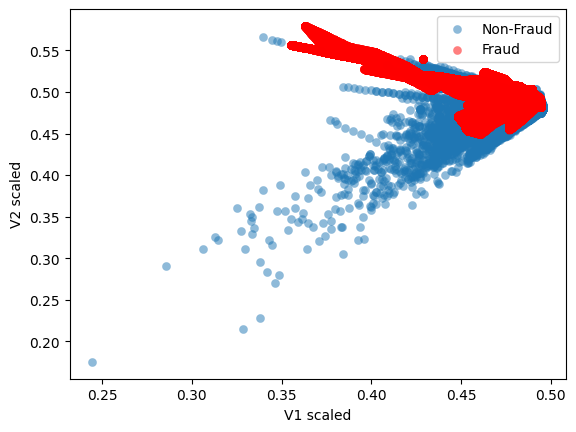

0    284315
1    284315
dtype: int64


In [13]:
#define resampling method: SMOTE
SMOTE = SMOTE()

#create resampled feature set
X_SMOTE, y_SMOTE = SMOTE.fit_resample(X, y)

#plot resampled data
plot_data(X_SMOTE, y_SMOTE)

#value counts resampled labels y_resampled
print(pd.value_counts(pd.Series(y_SMOTE)))

### Comparison of plots of resampled data

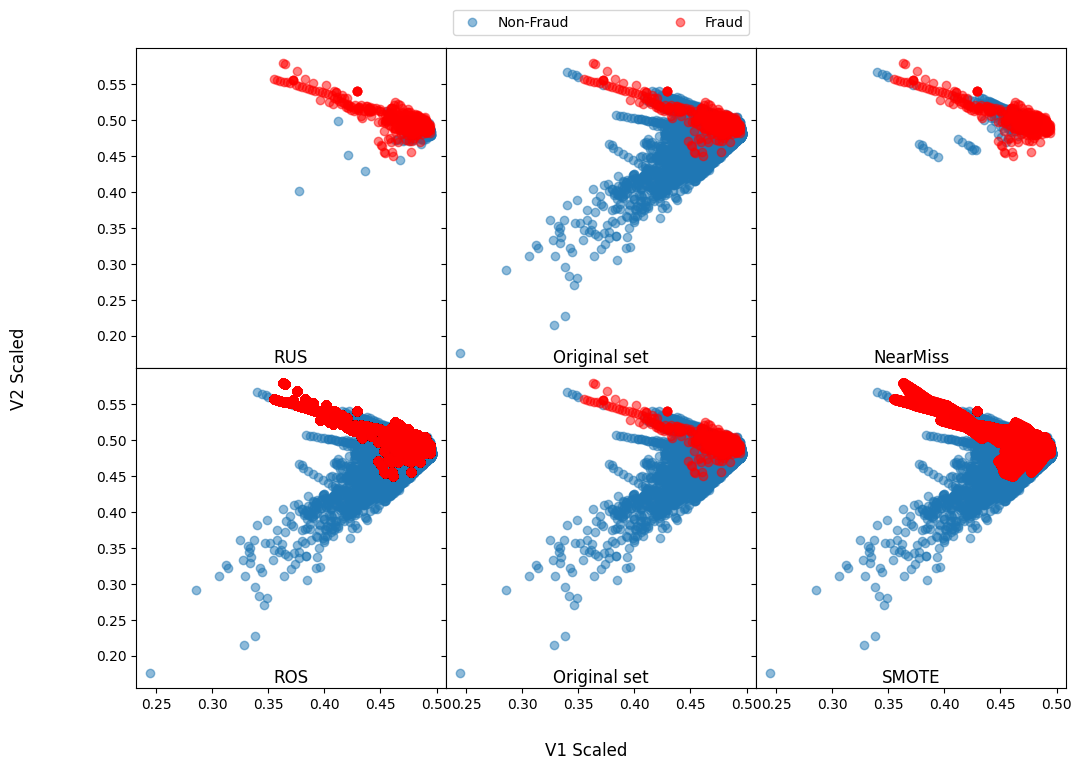

In [14]:
fig = plt.figure(figsize=(12,8), dpi=100)
gs = fig.add_gridspec(2,3, hspace=0, wspace=0)
(ax1, ax2, ax3), (ax4, ax5, ax6) = gs.subplots(sharex="col", sharey="row")
#fig.suptitle('Comparison of Resampling Methods')
# sub-plot number 1
c0=ax1.scatter(X_RUS[y_RUS == 0, 0], X_RUS[y_RUS == 0, 1], label = "Non-Fraud", alpha = 0.5)
c1=ax1.scatter(X_RUS[y_RUS == 1, 0], X_RUS[y_RUS == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax1.set_title("RUS", y=-0.01)
# sub-plot number 2
ax2.scatter(X[y == 0, 0], X[y == 0, 1], label = "Non-Fraud", alpha = 0.5)
ax2.scatter(X[y == 1, 0], X[y == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax2.set_title("Original set", y=-0.01)
ax2.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left", mode="expand", ncol=2)
# sub-plot number 3
ax3.scatter(X_NM2[y_NM2 == 0, 0], X_NM2[y_NM2 == 0, 1], label = "Non-Fraud", alpha = 0.5)
ax3.scatter(X_NM2[y_NM2 == 1, 0], X_NM2[y_NM2 == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax3.set_title("NearMiss", y=-0.01)
# sub-plot number 4
ax4.scatter(X_ROS[y_ROS == 0, 0], X_ROS[y_ROS == 0, 1], label = "Non-Fraud", alpha = 0.5)
ax4.scatter(X_ROS[y_ROS == 1, 0], X_ROS[y_ROS == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax4.set_title("ROS", y=-0.01)
# sub-plot number 5
ax5.scatter(X[y == 0, 0], X[y == 0, 1], label = "Non-Fraud", alpha = 0.5)
ax5.scatter(X[y == 1, 0], X[y == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax5.set_title("Original set", y=-0.01)
# sub-plot number 6
ax6.scatter(X_SMOTE[y_SMOTE == 0, 0], X_SMOTE[y_SMOTE == 0, 1], label = "Non-Fraud", alpha = 0.5)
ax6.scatter(X_SMOTE[y_SMOTE == 1, 0], X_SMOTE[y_SMOTE == 1, 1], label = "Fraud", alpha = 0.5, c='r')
ax6.set_title("SMOTE", y=-0.01)
    
for ax in fig.get_axes():
    ax.label_outer

fig.subplots_adjust(top=0.9,bottom=0.1)
#plt.figlegend((c0,c1), ("Non-Fraud", "Fraud"), loc = "", ncol=3, labelspacing = .5)
#plt.tight_layout(pad=3)
fig.supxlabel('V1 Scaled')
fig.supylabel('V2 Scaled')
plt.show()

## First simple Neural Network without Hidden Layer

In [15]:
# split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

### 1. Model: Training on Original Set

In [16]:
model1 = Sequential()
# Input layer
model1.add(Dense(1, input_shape=(29,), activation="tanh"))
# Add the output layer
model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model1.summary()
model1.fit(X_train, y_train, epochs = 5)
y_pred1 = model1.predict(X_test)
y_pred_classed1 = np.round(y_pred1)

2023-02-27 19:52:46.417046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 30        
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
7121/7121 [==============================] - 17s 2ms/step - loss: 0.0440 - accuracy: 0.9983
Epoch 2/5
7121/7121 [==============================] - 17s 2ms/step - loss: 0.0147 - accuracy: 0.9983
Epoch 3/5
7121/7121 [==============================] - 16s 2ms/step - loss: 0.0134 - accuracy: 0.9983
Epoch 4/5
7121/7121 [==============================] - 15s 2ms/step - loss: 0.0130 - accuracy: 0.9983
Epoch 5/5
1781/1781 [===========================

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.00      0.00      0.00       101

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9982268881008391
Precision:  0.0
Recall:  0.0
Specificity:  1.0
F1:  0.0
ROC-AUC Score:  0.9077986947847984
Average Precision Score:  0.4604449142791709
G-Mean:  0.0


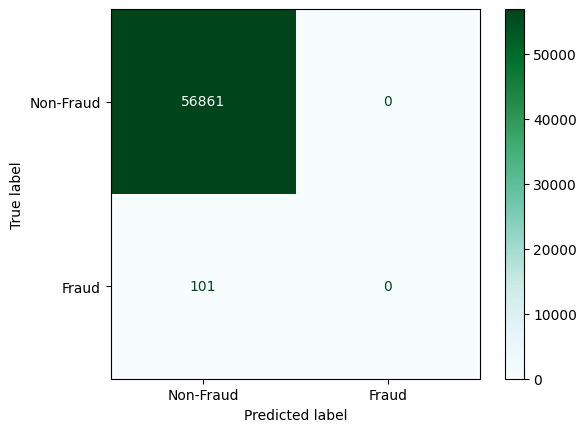

In [17]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed1))
performance1 = performance(y_test, y_pred1)
confusion_matrix = confusion_matrix(y_test, y_pred_classed1)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### 2. Model: Training on data resampled with Random Undersampling

In [18]:
method = RandomUnderSampler()
# Resampling only on training set
X_RUS, y_RUS = method.fit_resample(X_train, y_train)
model2 = Sequential()
model2.add(Dense(1, input_shape=(29,), activation="tanh"))
# Add the output layer
model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model2.summary()
# Fit on Resampled training set
model2.fit(X_RUS, y_RUS, epochs = 25)
#Prediction on test set (not resampled)
y_pred2 = model2.predict(X_test)
y_pred_classed2 = np.round(y_pred2)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 30        
                                                                 
 dense_3 (Dense)             (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
25/25 [==============================] - 1s 3ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 3/25
25/25 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 4/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6933 - accuracy: 0.5000
Epoch 5/25
25/25 [==============================] - 0s 4ms/ste

              precision    recall  f1-score   support

           0       0.91      0.00      0.00     56861
           1       0.00      0.93      0.00       101

    accuracy                           0.00     56962
   macro avg       0.46      0.47      0.00     56962
weighted avg       0.91      0.00      0.00     56962

Overall Accuracy:  0.002879112390716618
Precision:  0.0016524567109079723
Recall:  0.9306930693069307
Specificity:  0.0012310722639418935
F1:  0.003299055908468747
ROC-AUC Score:  0.31508310782538834
Average Precision Score:  0.0014300222586939048
G-Mean:  0.03921645073399397


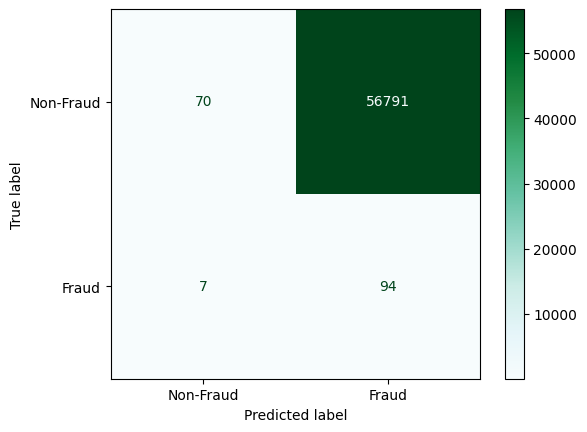

In [19]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed2))
performance2 = performance(y_test, y_pred2)
confusion_matrix = confusion_matrix(y_test, y_pred_classed2)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### 3. Model: Training on data resampled with Near Miss

In [20]:
### Model3: Near Miss
method = NearMiss(version=2)
X_NM2, y_NM2 = method.fit_resample(X_train, y_train)
model3 = Sequential()
model3.add(Dense(1, input_shape=(29,), activation="tanh"))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model3.summary()
model3.fit(X_NM2, y_NM2, epochs = 25)
y_pred3 = model3.predict(X_test)
y_pred_classed3 = np.round(y_pred3)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1)                 30        
                                                                 
 dense_5 (Dense)             (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
25/25 [==============================] - 1s 3ms/step - loss: 0.6969 - accuracy: 0.5000
Epoch 2/25
25/25 [==============================] - 0s 3ms/step - loss: 0.6963 - accuracy: 0.5000
Epoch 3/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6957 - accuracy: 0.5000
Epoch 4/25
25/25 [==============================] - 0s 2ms/step - loss: 0.6953 - accuracy: 0.5000
Epoch 5/25
25/25 [==============================] - 0s 2ms/ste

              precision    recall  f1-score   support

           0       0.83      0.00      0.00     56861
           1       0.00      0.87      0.00       101

    accuracy                           0.00     56962
   macro avg       0.41      0.44      0.00     56962
weighted avg       0.83      0.00      0.00     56962

Overall Accuracy:  0.002633334503704224
Precision:  0.0015469263627893896
Recall:  0.8712871287128713
Specificity:  0.0010903782909199627
F1:  0.003088369481294308
ROC-AUC Score:  0.2087465856027927
Average Precision Score:  0.0010855982607923978
G-Mean:  0.03671262764996552


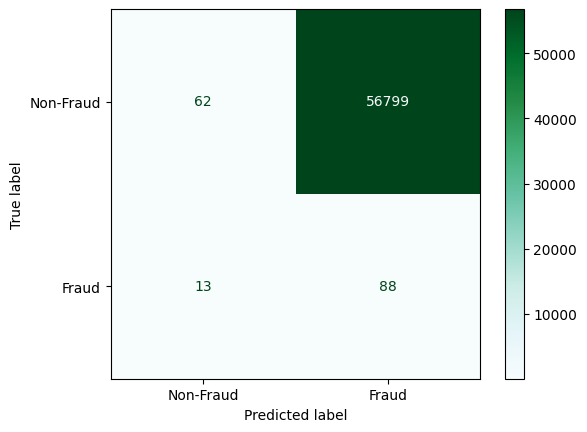

In [21]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed3))
performance3 = performance(y_test, y_pred3)
confusion_matrix = confusion_matrix(y_test, y_pred_classed3)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### 4. Model: Training on data resampled with Random Oversampling

In [22]:
### Model 4: Random Oversampling
method = RandomOverSampler()
X_ROS, y_ROS = method.fit_resample(X_train, y_train)
model4 = Sequential()
model4.add(Dense(1, input_shape=(29,), activation="tanh"))
model4.add(Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model4.summary()
model4.fit(X_ROS, y_ROS, epochs = 5)
y_pred4 = model4.predict(X_test)
y_pred_classed4 = np.round(y_pred4)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 30        
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.5892 - accuracy: 0.7804
Epoch 2/5
14216/14216 [==============================] - 29s 2ms/step - loss: 0.3446 - accuracy: 0.9003
Epoch 3/5
14216/14216 [==============================] - 33s 2ms/step - loss: 0.2579 - accuracy: 0.9116
Epoch 4/5
14216/14216 [==============================] - 36s 3ms/step - loss: 0.2255 - accuracy: 0.9192
Epoch 5/5
1781/1781 [=================

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56861
           1       0.13      0.88      0.23       101

    accuracy                           0.99     56962
   macro avg       0.57      0.94      0.61     56962
weighted avg       1.00      0.99      0.99     56962

Overall Accuracy:  0.9894666619851831
Precision:  0.13146233382570163
Recall:  0.8811881188118812
Specificity:  0.9896589929828881
F1:  0.22879177377892032
ROC-AUC Score:  0.9711089801933184
Average Precision Score:  0.7689585148055624
G-Mean:  0.3403572338565607


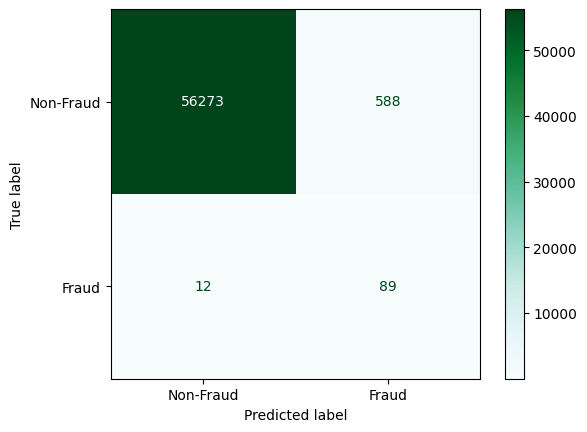

In [23]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed4))
performance4 = performance(y_test, y_pred4)
confusion_matrix = confusion_matrix(y_test, y_pred_classed4)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### 5. Model: Training on data resampled with SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
### Model 5: SMOTE
method = SMOTE()
X_SMOTE, y_SMOTE = method.fit_resample(X_train, y_train)
model5 = Sequential()
model5.add(Dense(1, input_shape=(29,), activation="tanh"))
model5.add(Dense(1, activation='sigmoid'))
model5.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model5.summary()
model5.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred5 = model5.predict(X_test)
y_pred_classed5 = np.round(y_pred5)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 1)                 30        
                                                                 
 dense_9 (Dense)             (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 39s 3ms/step - loss: 0.6547 - accuracy: 0.7494
Epoch 2/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.4072 - accuracy: 0.8916
Epoch 3/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.2754 - accuracy: 0.9083
Epoch 4/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.2327 - accuracy: 0.9157
Epoch 5/5
1781/1781 [=================

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56861
           1       0.10      0.89      0.19       101

    accuracy                           0.99     56962
   macro avg       0.55      0.94      0.59     56962
weighted avg       1.00      0.99      0.99     56962

Overall Accuracy:  0.9862364383273059
Precision:  0.10428736964078796
Recall:  0.8910891089108911
Specificity:  0.986405444856756
F1:  0.18672199170124482
ROC-AUC Score:  0.9737900013599257
Average Precision Score:  0.7753841819760275
G-Mean:  0.30484313881711433


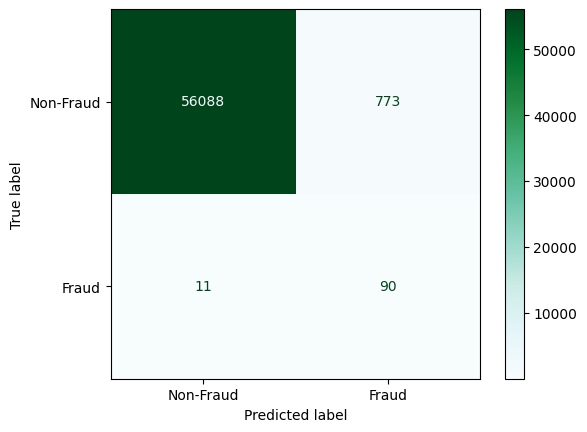

In [25]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed5))
performance5 = performance(y_test, y_pred5)
confusion_matrix = confusion_matrix(y_test, y_pred_classed5)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### Performance Heatmap:

In [26]:
metrics = ["Overall Accuracy", "Precision", "Recall", "Specificity",
              "F1", "ROC-AUC", "AUPRC", "G_mean"]
models = ["Original Set", "RUS", "NearMiss",
           "ROS", "SMOTE"]

per1 = performance(y_test, y_pred1)
per2 = performance(y_test, y_pred2)
per3 = performance(y_test, y_pred3)
per4 = performance(y_test, y_pred4)
per5 = performance(y_test, y_pred5)

performance = np.array([(per1),(per2),(per3),(per4),(per5)]).transpose()

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Accuracy:  0.9982268881008391
Precision:  0.0
Recall:  0.0
Specificity:  1.0
F1:  0.0
ROC-AUC Score:  0.9077986947847984
Average Precision Score:  0.4604449142791709
G-Mean:  0.0
Overall Accuracy:  0.002879112390716618
Precision:  0.0016524567109079723
Recall:  0.9306930693069307
Specificity:  0.0012310722639418935
F1:  0.003299055908468747
ROC-AUC Score:  0.31508310782538834
Average Precision Score:  0.0014300222586939048
G-Mean:  0.03921645073399397
Overall Accuracy:  0.002633334503704224
Precision:  0.0015469263627893896
Recall:  0.8712871287128713
Specificity:  0.0010903782909199627
F1:  0.003088369481294308
ROC-AUC Score:  0.2087465856027927
Average Precision Score:  0.0010855982607923978
G-Mean:  0.03671262764996552
Overall Accuracy:  0.9894666619851831
Precision:  0.13146233382570163
Recall:  0.8811881188118812
Specificity:  0.9896589929828881
F1:  0.22879177377892032
ROC-AUC Score:  0.9711089801933184
Average Precision Score:  0.7689585148055624
G-Mean:  0.3403572338565

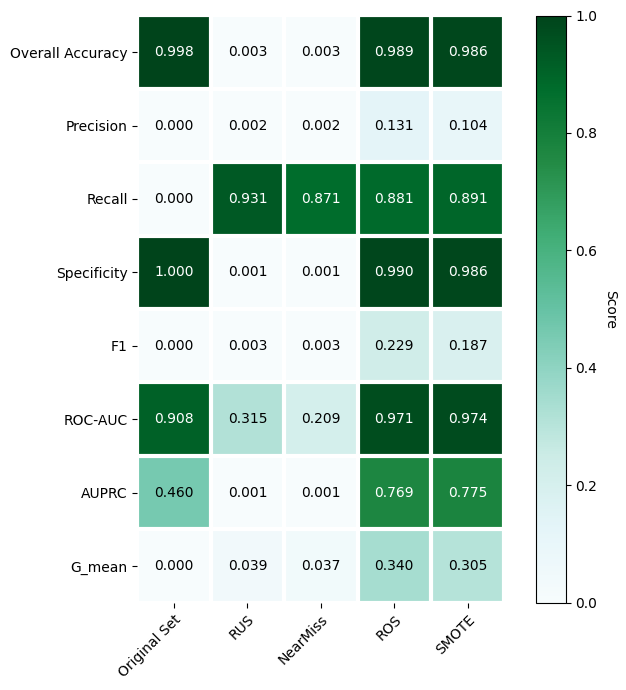

In [27]:
fig, ax = plt.subplots(figsize=(7,7))

im, cbar = heatmap(performance, metrics, models, ax=ax, cmap="BuGn", cbarlabel="Score")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()

## Hyperprameters Tuning by hand

 ### Using Model 5 as baseline model (Neural Network 1)

#### Neural Network 2: adjusting learning rate using learning rate = 0.1

In [28]:
#Souce: https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594

#adjusting learning rate
# NN 2: learning rate = 0.1
from keras.optimizers import SGD
epochs=5
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)


/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1)                 30        
                                                                 
 dense_11 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 43s 3ms/step - loss: 0.6883 - accuracy: 0.6833
Epoch 2/5
14216/14216 [==============================] - 40s 3ms/step - loss: 0.6798 - accuracy: 0.8380
Epoch 3/5
14216/14216 [==============================] - 35s 2ms/step - loss: 0.6723 - accuracy: 0.8470
Epoch 4/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.6653 - accuracy: 0.8535
Epoch 5/5
1781/1781 [=================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.86      0.59      0.70       101

    accuracy                           1.00     56962
   macro avg       0.93      0.80      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9991046662687406
Precision:  0.8571428571428571
Recall:  0.594059405940594
Specificity:  0.9998241325337226
F1:  0.7017543859649122
ROC-AUC Score:  0.9400192688057607
Average Precision Score:  0.7401830440100119
G-Mean:  0.7135781502544126


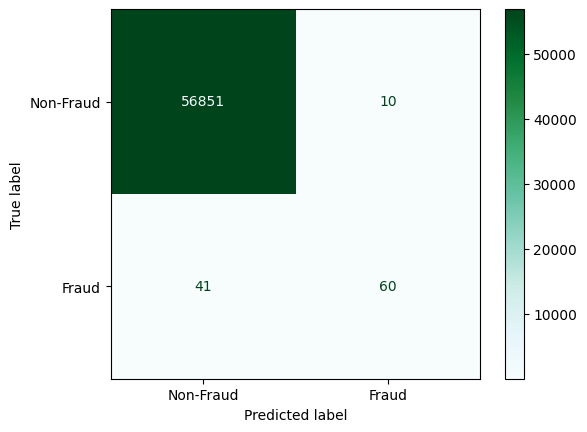

In [36]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance1 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 3: adjusting learning rate using learning rate = 0.2

In [37]:
#NN3: learning rate = 0.2
epochs=5
learning_rate = 0.2
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1)                 30        
                                                                 
 dense_13 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 55s 4ms/step - loss: 0.5022 - accuracy: 0.8696
Epoch 2/5
14216/14216 [==============================] - 60s 4ms/step - loss: 0.4295 - accuracy: 0.8961
Epoch 3/5
14216/14216 [==============================] - 64s 5ms/step - loss: 0.4066 - accuracy: 0.8973
Epoch 4/5
14216/14216 [==============================] - 37s 3ms/step - loss: 0.3932 - accuracy: 0.8976
Epoch 5/5
1781/1781 [=================

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.81      0.82      0.82       101

    accuracy                           1.00     56962
   macro avg       0.91      0.91      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9993504441557529
Precision:  0.8137254901960784
Recall:  0.8217821782178217
Specificity:  0.999665851814073
F1:  0.8177339901477833
ROC-AUC Score:  0.9667429397483285
Average Precision Score:  0.7431990362986767
G-Mean:  0.8177439121171726


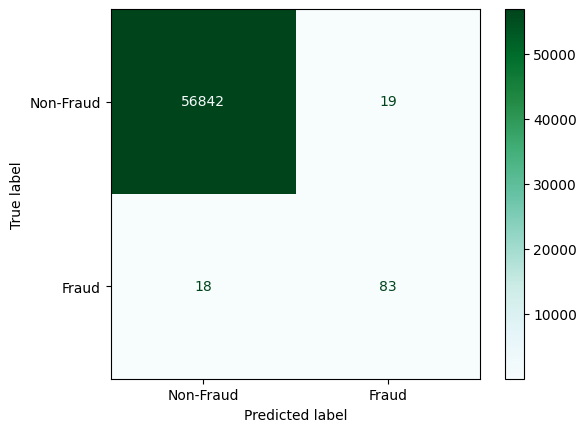

In [38]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance2 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 4: adjusting learning rate using learning rate = 0.05

In [39]:
#NN 4: learning rate = 0.05
epochs=5
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 1)                 30        
                                                                 
 dense_15 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
14216/14216 [==============================] - 36s 2ms/step - loss: 0.5855 - accuracy: 0.8376
Epoch 2/5
14216/14216 [==============================] - 29s 2ms/step - loss: 0.5073 - accuracy: 0.8781
Epoch 3/5
14216/14216 [==============================] - 29s 2ms/step - loss: 0.4760 - accuracy: 0.8878
Epoch 4/5
14216/14216 [==============================] - 30s 2ms/step - loss: 0.4571 - accuracy: 0.8925
Epoch 5/5
1781/1781 [==============================] - 3s 1ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.83      0.79      0.81       101

    accuracy                           1.00     56962
   macro avg       0.92      0.90      0.91     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9993504441557529
Precision:  0.8333333333333334
Recall:  0.7920792079207921
Specificity:  0.9997186120539562
F1:  0.8121827411167514
ROC-AUC Score:  0.9590137387316404
Average Precision Score:  0.7480151046865428
G-Mean:  0.8124444637023875


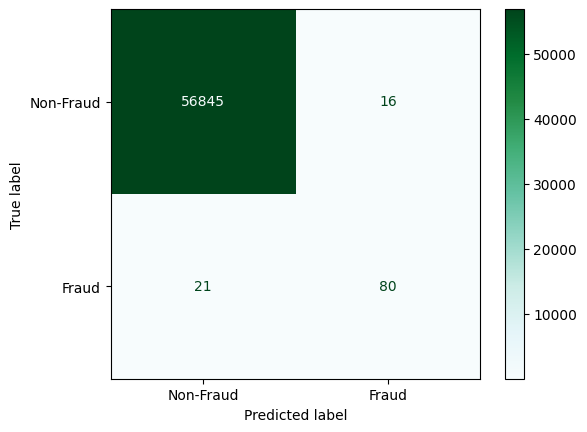

In [40]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance3 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 5: learning rate = 0.05 + higher number of epochs

In [41]:
#NN5: learning rate = 0.05, number of epochs = 10
epochs=5
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 10)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 1)                 30        
                                                                 
 dense_17 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
14216/14216 [==============================] - 43s 2ms/step - loss: 0.6056 - accuracy: 0.8314
Epoch 2/10
14216/14216 [==============================] - 29s 2ms/step - loss: 0.5319 - accuracy: 0.8843
Epoch 3/10
14216/14216 [==============================] - 28s 2ms/step - loss: 0.4997 - accuracy: 0.8907
Epoch 4/10
14216/14216 [==============================] - 30s 2ms/step - loss: 0.4799 - accuracy: 0.8930
Epoch 5/10
14216/14216 [==============================] - 31s 2ms/step - loss: 0.4659 - accuracy: 0.8942
Epoch 6/10
14216/14216 [==============================] - 37s 3ms/step - loss: 0.4552 - accuracy: 0.8949
Epoch 7/10
14216/14216 [==============================] - 29s 2ms/step - loss: 0.4466 - accuracy: 0.8954
Epoch 8/10
14216/14216 [==============================] - 28s 2ms/step - loss: 0.4395 - accuracy: 0.8959
Epoch 9/10
14216/14216 [==============================] - 28s 2ms/step - loss: 0.4335 - accuracy: 0.8963
Epoch 10/10
1781/1781 [==============================] 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.88      0.80      0.84       101

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9994557775359011
Precision:  0.8804347826086957
Recall:  0.801980198019802
Specificity:  0.9998065457870948
F1:  0.839378238341969
ROC-AUC Score:  0.9568490017605901
Average Precision Score:  0.7580385479414695
G-Mean:  0.8402923665606175


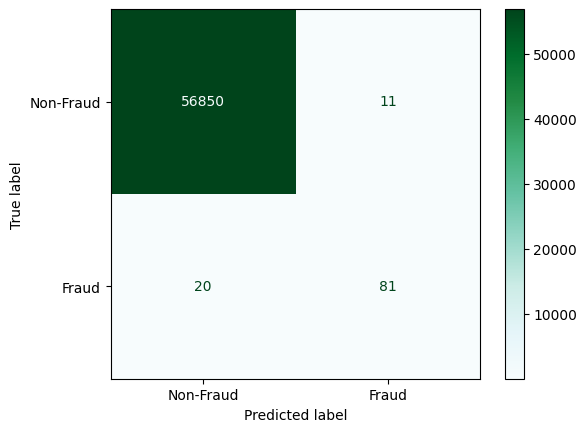

In [42]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance4 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 6: learning rate = 0.05, batch size = 1000, number of epochs = 5

In [43]:
epochs=5
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, batch_size = 1000, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 1)                 30        
                                                                 
 dense_19 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/5
455/455 [==============================] - 4s 3ms/step - loss: 0.6892 - accuracy: 0.6420
Epoch 2/5
455/455 [==============================] - 1s 3ms/step - loss: 0.6747 - accuracy: 0.8499
Epoch 3/5
455/455 [==============================] - 1s 3ms/step - loss: 0.6644 - accuracy: 0.8771
Epoch 4/5
455/455 [==============================] - 1s 3ms/step - loss: 0.6553 - accuracy: 0.8775
Epoch 5/5
1781/1781 [==============================] - 3s 2ms/step


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.34      0.79      0.47       101

    accuracy                           1.00     56962
   macro avg       0.67      0.89      0.74     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.996892665285629
Precision:  0.3389830508474576
Recall:  0.7920792079207921
Specificity:  0.9972564675260723
F1:  0.47477744807121663
ROC-AUC Score:  0.9713754803489001
Average Precision Score:  0.5078884135654359
G-Mean:  0.5181712327154295


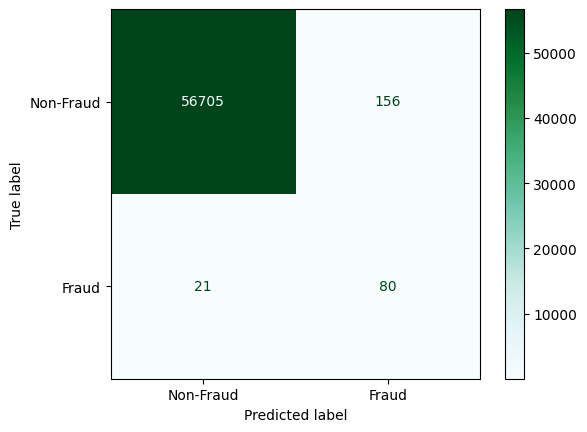

In [44]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance5 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 7: 1 Hidden Layer, tanh as activation function

In [45]:
# NN 7: 1 Hidden Layer, tanh, tanh
# Hidden Layer
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 1)                 30        
                                                                 
 dense_21 (Dense)            (None, 10)                20        
                                                                 
 dense_22 (Dense)            (None, 1)                 11        
                                                                 
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 41s 3ms/step - loss: 0.6242 - accuracy: 0.6762
Epoch 2/5
14216/14216 [==============================] - 31s 2ms/step - loss: 0.3097 - accuracy: 0.8815
Epoch 3/5
14216/14216 [==============================] - 31s 2ms/step - loss: 0.2428 - accuracy: 0.9101
Epoch 4/5

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.07      0.93      0.12       101

    accuracy                           0.98     56962
   macro avg       0.53      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Overall Accuracy:  0.9768617674941189
Precision:  0.06690391459074733
Recall:  0.9306930693069307
Specificity:  0.9769437751710311
F1:  0.12483399734395752
ROC-AUC Score:  0.9750087106633669
Average Precision Score:  0.7654945572647927
G-Mean:  0.24953358415073387


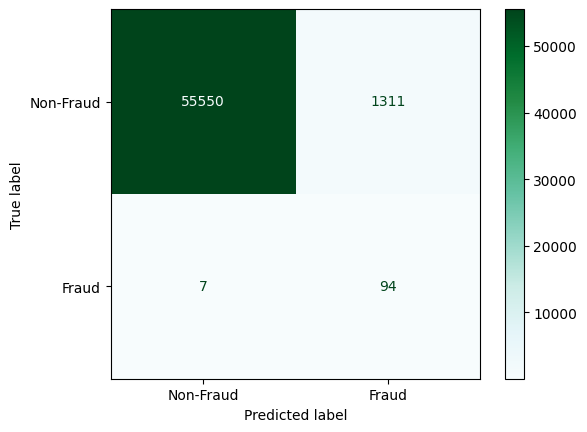

In [46]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance6 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 8: 1 Hidden Layer, activation function tanh, change of number of neurons

In [47]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(7, activation="tanh")) #more neurons
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_23 (Dense)            (None, 1)                 30        
                                                                 
 dense_24 (Dense)            (None, 10)                20        
                                                                 
 dense_25 (Dense)            (None, 7)                 77        
                                                                 
 dense_26 (Dense)            (None, 1)                 8         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 45s 3ms/step - loss: 0.5303 - accuracy: 0.7214
Epoch 2/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.275

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.08      0.91      0.15       101

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.57     56962
weighted avg       1.00      0.98      0.99     56962

Overall Accuracy:  0.981285769460342
Precision:  0.08006962576153177
Recall:  0.9108910891089109
Specificity:  0.9814108088144774
F1:  0.14720000000000003
ROC-AUC Score:  0.9709498288426475
Average Precision Score:  0.7666119835846354
G-Mean:  0.2700642675632313


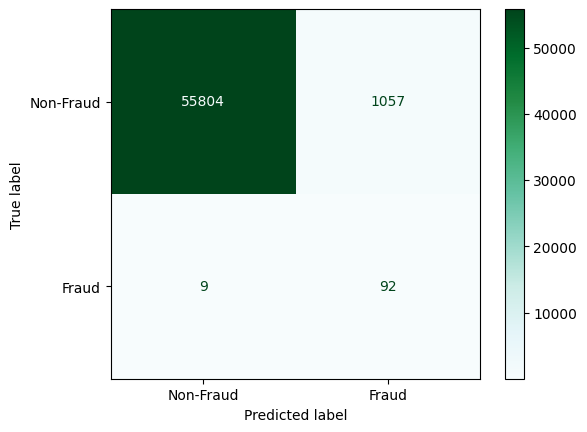

In [48]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance7 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 9: 3 Hidden Layer, activation function tanh, change of number of neurons

In [49]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(15, activation="tanh"))
model.add(Dense(5, activation="tanh")) 
model.add(Dense(3, activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 1)                 30        
                                                                 
 dense_28 (Dense)            (None, 15)                30        
                                                                 
 dense_29 (Dense)            (None, 5)                 80        
                                                                 
 dense_30 (Dense)            (None, 3)                 18        
                                                                 
 dense_31 (Dense)            (None, 1)                 4         
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] 

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.00      0.00      0.00       101

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9982268881008391
Precision:  0.0
Recall:  0.0
Specificity:  1.0
F1:  0.0
ROC-AUC Score:  0.9595392516160217
Average Precision Score:  0.7618716494516761
G-Mean:  0.0


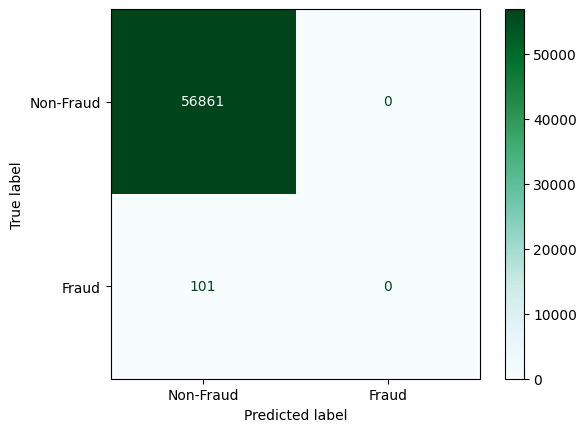

In [50]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance8 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 10: 2 Hidden Layers, activation function tanh and relu, change of number of neurons

In [51]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(7, activation="relu")) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 1)                 30        
                                                                 
 dense_33 (Dense)            (None, 10)                20        
                                                                 
 dense_34 (Dense)            (None, 7)                 77        
                                                                 
 dense_35 (Dense)            (None, 1)                 8         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 33s 2ms/step - loss: 0.6923 - accuracy: 0.5341
Epoch 2/5
14216/14216 [==============================] - 30s 2ms/step - loss: 0.479

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56861
           1       0.05      0.94      0.10       101

    accuracy                           0.97     56962
   macro avg       0.53      0.96      0.54     56962
weighted avg       1.00      0.97      0.98     56962

Overall Accuracy:  0.970664653628735
Precision:  0.05397727272727273
Recall:  0.9405940594059405
Specificity:  0.9707180668648107
F1:  0.10209564750134337
ROC-AUC Score:  0.9731918778483782
Average Precision Score:  0.775364125213031
G-Mean:  0.22532354974615285


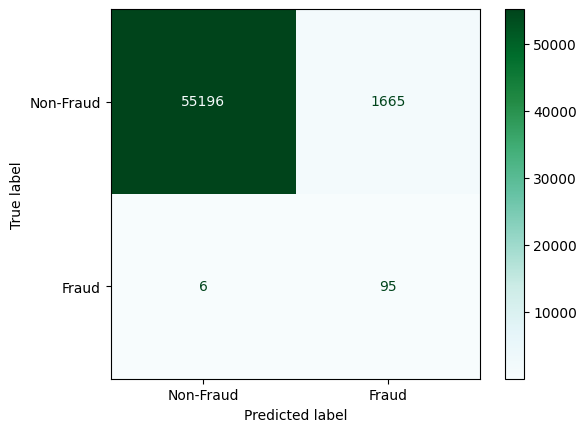

In [52]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance9 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 11: 2 Hidden Layers, activation function sigmoid, tanh and linear

In [53]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="sigmoid"))
model.add(Dense(10, activation="tanh"))
model.add(Dense(7, activation="linear")) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 1)                 30        
                                                                 
 dense_37 (Dense)            (None, 10)                20        
                                                                 
 dense_38 (Dense)            (None, 7)                 77        
                                                                 
 dense_39 (Dense)            (None, 1)                 8         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 37s 2ms/step - loss: 0.6850 - accuracy: 0.6009
Epoch 2/5
14216/14216 [==============================] - 34s 2ms/step - loss: 0.410

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56861
           1       0.07      0.93      0.13       101

    accuracy                           0.98     56962
   macro avg       0.54      0.95      0.56     56962
weighted avg       1.00      0.98      0.99     56962

Overall Accuracy:  0.9782662125627611
Precision:  0.0709433962264151
Recall:  0.9306930693069307
Specificity:  0.9783507149012504
F1:  0.13183730715287517
ROC-AUC Score:  0.9737536089832406
Average Precision Score:  0.7228773256786825
G-Mean:  0.25695627484266653


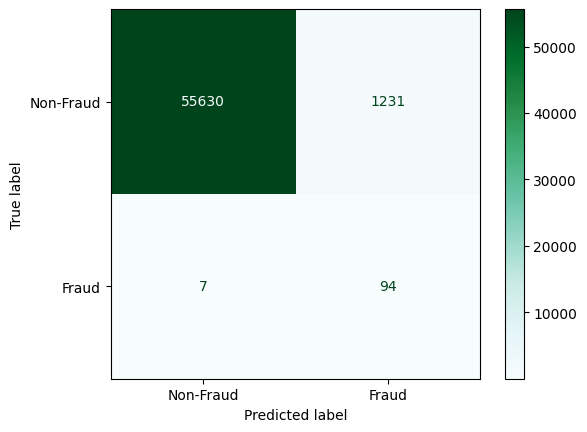

In [54]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance10 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 12: 2 Hidden Layers, activation function sigmoid

In [55]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="sigmoid"))
model.add(Dense(10, activation="sigmoid"))
model.add(Dense(7, activation="sigmoid")) 
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 1)                 30        
                                                                 
 dense_41 (Dense)            (None, 10)                20        
                                                                 
 dense_42 (Dense)            (None, 7)                 77        
                                                                 
 dense_43 (Dense)            (None, 1)                 8         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 34s 2ms/step - loss: 0.6932 - accuracy: 0.4999
Epoch 2/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.693

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56861
           1       0.00      1.00      0.00       101

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962

Overall Accuracy:  0.001773111899160844
Precision:  0.001773111899160844
Recall:  1.0
Specificity:  0.0
F1:  0.003539947076038764
ROC-AUC Score:  0.2742579132959461
Average Precision Score:  0.0013159204351600353
G-Mean:  0.042108335269407694


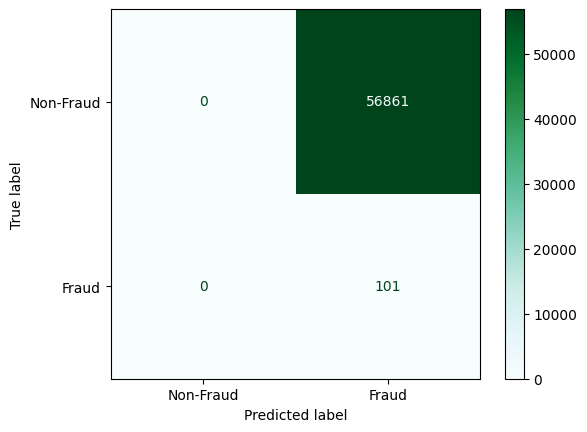

In [56]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance11 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 13: 2 Hidden Layers, activation function relu

In [57]:
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="relu"))
model.add(Dense(10, activation="relu"))
model.add(Dense(7, activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 1)                 30        
                                                                 
 dense_45 (Dense)            (None, 10)                20        
                                                                 
 dense_46 (Dense)            (None, 7)                 77        
                                                                 
 dense_47 (Dense)            (None, 1)                 8         
                                                                 
Total params: 135
Trainable params: 135
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 37s 2ms/step - loss: 0.6932 - accuracy: 0.4986
Epoch 2/5
14216/14216 [==============================] - 36s 3ms/step - loss: 0.693

/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

              precision    recall  f1-score   support

           0       0.00      0.00      0.00     56861
           1       0.00      1.00      0.00       101

    accuracy                           0.00     56962
   macro avg       0.00      0.50      0.00     56962
weighted avg       0.00      0.00      0.00     56962

Overall Accuracy:  0.001773111899160844
Precision:  0.001773111899160844
Recall:  1.0
Specificity:  0.0
F1:  0.003539947076038764
ROC-AUC Score:  0.5
Average Precision Score:  0.001773111899160844
G-Mean:  0.042108335269407694


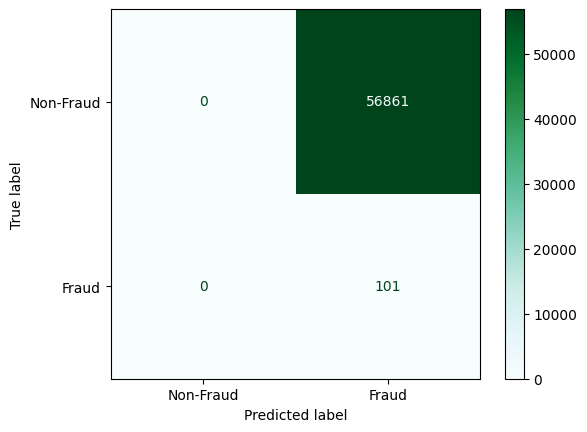

In [58]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance12 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

#### Neural Network 14: learning rate = 0.05, batch size = 1000, number of epochs = 100

In [59]:
epochs=5
learning_rate = 0.05
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, batch_size = 1000, epochs = 100)
y_pred = model.predict(X_test)
y_pred_classed = np.round(y_pred)

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 1)                 30        
                                                                 
 dense_49 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________


/usr/local/Caskroom/miniforge/base/envs/myenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/100
455/455 [==============================] - 2s 3ms/step - loss: 0.6934 - accuracy: 0.4755
Epoch 2/100
455/455 [==============================] - 2s 4ms/step - loss: 0.6932 - accuracy: 0.4949
Epoch 3/100
455/455 [==============================] - 1s 3ms/step - loss: 0.6932 - accuracy: 0.4958
Epoch 4/100
455/455 [==============================] - 2s 3ms/step - loss: 0.6931 - accuracy: 0.5091
Epoch 5/100
455/455 [==============================] - 2s 4ms/step - loss: 0.6931 - accuracy: 0.5262
Epoch 6/100
455/455 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5375
Epoch 7/100
455/455 [==============================] - 1s 3ms/step - loss: 0.6931 - accuracy: 0.5096
Epoch 8/100
455/455 [==============================] - 2s 4ms/step - loss: 0.6931 - accuracy: 0.5831
Epoch 9/100
455/455 [==============================] - 2s 4ms/step - loss: 0.6930 - accuracy: 0.5842
Epoch 10/100
455/455 [==============================] - 2s 3ms/step - loss: 0.6930 - accura

455/455 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.6669
Epoch 82/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6919 - accuracy: 0.6633
Epoch 83/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6598
Epoch 84/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6646
Epoch 85/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6567
Epoch 86/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6621
Epoch 87/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6541
Epoch 88/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6918 - accuracy: 0.6631
Epoch 89/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 0.6609
Epoch 90/100
455/455 [==============================] - 1s 2ms/step - loss: 0.6917 - accuracy: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.76      0.34      0.47       101

    accuracy                           1.00     56962
   macro avg       0.88      0.67      0.73     56962
weighted avg       1.00      1.00      1.00     56962

Overall Accuracy:  0.9986306660580738
Precision:  0.7555555555555555
Recall:  0.33663366336633666
Specificity:  0.9998065457870948
F1:  0.4657534246575343
ROC-AUC Score:  0.8710585880698127
Average Precision Score:  0.4223824414414564
G-Mean:  0.5043267140886495


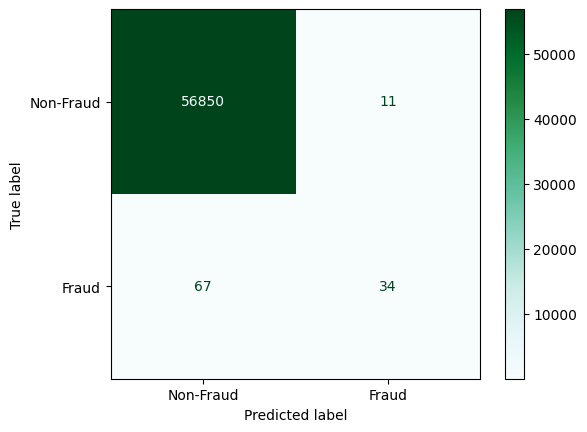

In [60]:
# Performance Metrics
from sklearn.metrics import confusion_matrix
print(classification_report(y_test, y_pred_classed))
performance13 = performance(y_test, y_pred)
confusion_matrix = confusion_matrix(y_test, y_pred_classed)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")

plt.show()

##### Neural Network 15: optimizer = Adam

In [61]:
from imblearn.over_sampling import SMOTE
### Model 5: SMOTE
method = SMOTE()
X_SMOTE, y_SMOTE = method.fit_resample(X_train, y_train)
model = Sequential()
model.add(Dense(1, input_shape=(29,), activation="tanh"))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(X_SMOTE, y_SMOTE, epochs = 5)
y_pred_smote = model.predict(X_test)
y_pred_classed_smote = np.round(y_pred_smote)

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 1)                 30        
                                                                 
 dense_51 (Dense)            (None, 1)                 2         
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
14216/14216 [==============================] - 32s 2ms/step - loss: 0.4654 - accuracy: 0.8535
Epoch 2/5
14216/14216 [==============================] - 29s 2ms/step - loss: 0.2562 - accuracy: 0.9086
Epoch 3/5
14216/14216 [==============================] - 31s 2ms/step - loss: 0.2090 - accuracy: 0.9213
Epoch 4/5
14216/14216 [==============================] - 30s 2ms/step - loss: 0.1911 - accuracy: 0.9295
Epoch 5/5
1781/1781 [================

Overall Accuracy:  0.9875004388890839
Precision:  0.11378002528445007
Recall:  0.8910891089108911
Specificity:  0.9876716906139533
F1:  0.2017937219730942
ROC-AUC Score:  0.9703411706957439
Average Precision Score:  0.7325351722895184
G-Mean:  0.31841504572268453


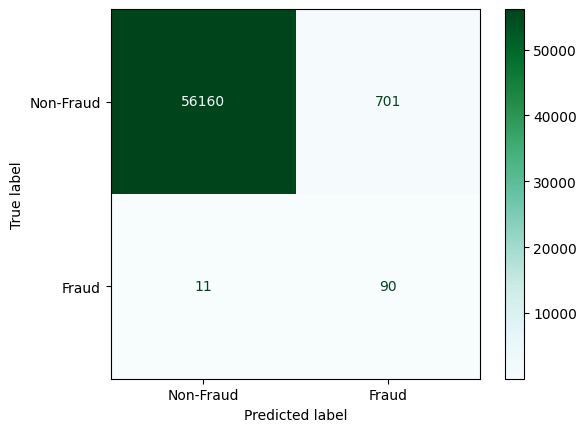

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_classed_smote)
performance14 = performance(y_test, y_pred_smote)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

## Benchmark Models

### 1. Logistic Regression

In [65]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_SMOTE, y_SMOTE)
y_pred_lr = logreg.predict_proba(X_test)[:, 1]
y_pred_classed_lr = np.round(y_pred_lr)

Overall Accuracy:  0.9888346617042941
Precision:  0.1258741258741259
Recall:  0.8910891089108911
Specificity:  0.9890082833576617
F1:  0.22058823529411767
ROC-AUC Score:  0.9806387332248991
Average Precision Score:  0.7593797887695598
G-Mean:  0.33491052933598875


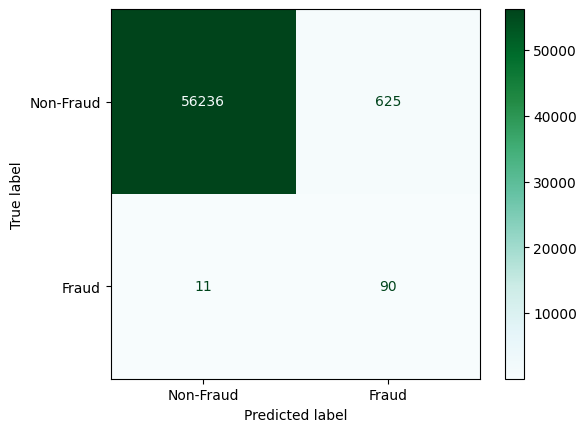

In [66]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_classed_lr)
performance_lr = performance(y_test, y_pred_lr )

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

### 2. Random Forest

In [67]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
###Random Forest Classifier

#define model as random forest
model = RandomForestClassifier(random_state=5)

#fit model to training set
model.fit(X_SMOTE, y_SMOTE)

#obtain predictions from test data
y_pred_classed_rf = model.predict(X_test)

###Performance metrics for RF model
#predictions of probabilities from RF
y_pred_rf = model.predict_proba(X_test)

Overall Accuracy:  0.9994733330992591
Precision:  0.865979381443299
Recall:  0.8316831683168316
Specificity:  0.9997713722938394
F1:  0.8484848484848486
ROC-AUC Score:  0.9758301510318457
Average Precision Score:  0.8634650759230855
G-Mean:  0.8486580440058369


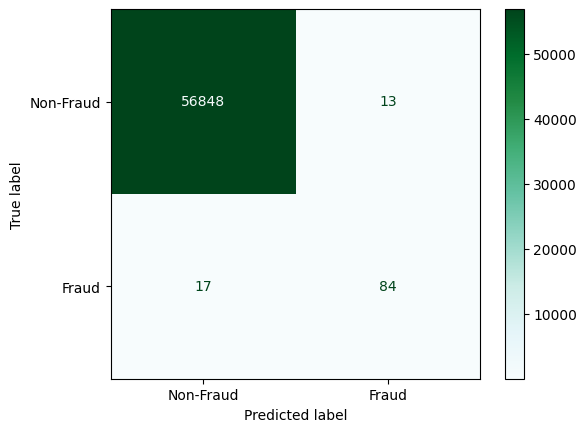

In [68]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred_classed_rf)
performance_rf = performance(y_test, y_pred_rf[:, 1])

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Non-Fraud", "Fraud"])

cm_display.plot(cmap="BuGn")
plt.show()

## Performance Comparison

In [69]:
# Performance of simple nn trained with SMOTE
performance_nn1 = performance(y_test, y_pred5)

Overall Accuracy:  0.9862364383273059
Precision:  0.10428736964078796
Recall:  0.8910891089108911
Specificity:  0.986405444856756
F1:  0.18672199170124482
ROC-AUC Score:  0.9737900013599257
Average Precision Score:  0.7753841819760275
G-Mean:  0.30484313881711433


In [89]:
#### Performance Heatmap ####
metrics = ["Overall Accuracy", "Precision", "Recall", "Specificity",
              "F1", "ROC-AUC", "AUPRC", "G_mean"]
models = ["LR", "RF", "NN1", "NN2", "NN3", "NN4", "NN5", "NN6", "NN7", "NN8", "NN9", "NN10","NN11","NN12","NN13","NN14","NN15"]

performance_models = np.array([(performance_lr),(performance_rf),(performance_nn1),(performance1),(performance2),(performance3),(performance4),(performance5),(performance6),(performance7),(performance8),(performance9),(performance10),(performance11),(performance12),(performance13),(performance14)]).transpose()

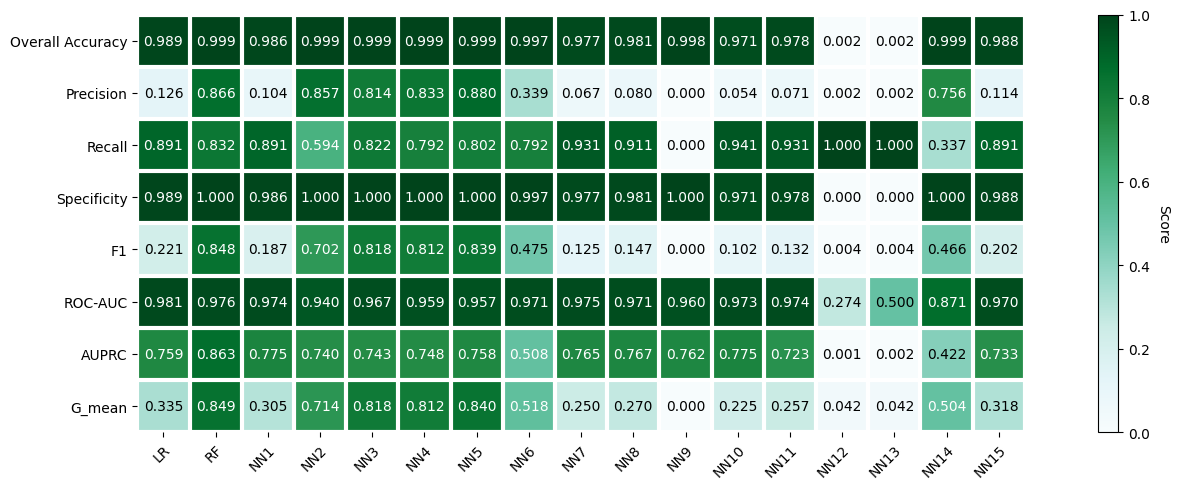

In [102]:
fig, ax = plt.subplots(figsize=(15, 5))

im, cbar = heatmap(performance_models, metrics, models, ax=ax, cmap="BuGn", cbarlabel="Score")
texts = annotate_heatmap(im, valfmt="{x:.3f}")

fig.tight_layout()
plt.show()